In [1]:
from sklearn.ensemble import VotingClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import pipeline
import pickle
%matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from mlxtend.classifier import EnsembleVoteClassifier

import src.utils as utils

In [31]:
X_final_test

,vbow_0,vbow_1,vbow_2,vbow_3,vbow_4,vbow_5,vbow_6,vbow_7,vbow_8,vbow_9,...,cnn_2014,cnn_2019,cnn_2020,cnn_2021,cnn_2022,cnn_2024,cnn_2029,cnn_2041,cnn_2044,cnn_2047
6/10-23-14/11-16-17,2.0,17.0,24.0,12.0,9.0,18.0,10.0,10.0,12.0,9.0,...,-0.086636,0.594616,0.438078,-0.726048,-0.575115,-0.408219,0.634305,-0.021134,0.279492,-0.104284
7/4-10-12/5-28-15,11.0,4.0,12.0,17.0,11.0,4.0,4.0,5.0,8.0,8.0,...,-0.390384,-0.564133,-0.192634,-0.251353,0.012194,0.065411,-0.314697,0.007431,0.414059,-0.030240
2/12-11-12/12-17-13,15.0,4.0,3.0,5.0,11.0,2.0,6.0,5.0,4.0,9.0,...,0.979832,-0.581350,-0.470310,0.353063,-0.269360,-0.204492,-0.212497,-1.006278,-0.234104,-0.001605
24/3-11-14/8-14-14,2.0,7.0,8.0,12.0,7.0,8.0,5.0,7.0,3.0,15.0,...,-0.061136,-0.131739,-0.434585,-0.396457,0.555140,-0.049515,0.093676,0.117561,-0.625611,-0.102479
24b/3-11-14/8-14-14,3.0,12.0,8.0,18.0,6.0,12.0,9.0,9.0,9.0,4.0,...,0.047013,0.828833,0.452950,-0.062897,0.363284,0.678711,-0.026908,0.359598,-0.501149,0.406217
32/12-17-15/1-5-17,19.0,5.0,9.0,5.0,14.0,9.0,8.0,1.0,2.0,7.0,...,0.549963,-0.674594,-0.021383,-0.665304,-0.235457,-0.679874,-0.582289,-0.038993,0.155165,-0.683775
41/1-25-11/8-7-12,8.0,7.0,4.0,12.0,29.0,8.0,3.0,19.0,6.0,14.0,...,-0.326672,0.113593,-0.193529,-0.176102,0.093235,0.045863,0.294768,0.039116,0.044953,0.465247


In [2]:

#inputs is a map of format {name: input_file.csv}
# NOTE only cnn input should contain y
def construct_dataframe(inputs):
    df_X = []
    y = []
    for prefix, filename in inputs.items():
        data = pd.read_pickle(filename).drop_duplicates()

        if prefix == 'cnn':
            y = data['y']
            data_X = data.drop('y', axis=1).add_prefix(prefix + "_")
        else:
            data_X = data.add_prefix(prefix + "_")
        
        df_X.append(data_X)
    return pd.concat(df_X, axis=1, sort=False), y

def split_train_test(X,y):
    test_X = X.loc[utils.TEST_KEYS]
    train_X = X.loc[X.index.difference(utils.TEST_KEYS)]
    test_y = y.loc[utils.TEST_KEYS]
    train_y = y.loc[y.index.difference(utils.TEST_KEYS)]
    return train_X, train_y, test_X, test_y

In [3]:
'''
import pickle
d = pd.read_pickle("vbow/vbow-orb-50-ensemble-full.pkl")
d.index = d.index.str.replace(".tif", "")
pickle.dump(d, open("vbow/vbow-orb-50-ensemble-full.pkl", 'wb'))
'''

'\nimport pickle\nd = pd.read_pickle("vbow/vbow-orb-50-ensemble-full.pkl")\nd.index = d.index.str.replace(".tif", "")\npickle.dump(d, open("vbow/vbow-orb-50-ensemble-full.pkl", \'wb\'))\n'

In [12]:
input_data = {
    "cnn": "inception/data2_inception_cnn_diff_reduced_dim_augmented.pkl",
    "vbow": "vbow/vbow-orb-50-ensemble-full.pkl"
}
X, y = construct_dataframe(input_data)
X, y, X_final_test,y_final_test  = split_train_test(X, y)


In [13]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, pref):
        self.pref = pref

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        filter_cols = [col for col in X if col.startswith(self.pref)]
        return X[filter_cols]

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

cnn_multi = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', LogisticRegression(solver='lbfgs', penalty='l2', C= 0.1, multi_class="multinomial", max_iter=3000))
])

cnn_binary = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', LogisticRegression(solver='liblinear', penalty='l2', C= 1, max_iter=3000))
])

cnn_pretrained_binary = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', pickle.load(open("inception/lr_binary_reduced_model_aug.pkl","rb")))
])

cnn_pretrained_multi = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', pickle.load(open("inception/lr_binary_reduced_model_aug_strat.pkl","rb")))
])

vbow = pipeline.Pipeline([
    ('col_extract_vbow', ColumnExtractor("vbow_")),
    ('vbow_model', SVC(C=10, gamma=0.001, probability=True))
])

vbow_bayes = pipeline.Pipeline([
    ('col_extract_vbow', ColumnExtractor("vbow_")),
    ('vbow_model', GaussianNB())
])

In [15]:
eclf_binary = VotingClassifier(estimators=[('cnn',cnn_binary),('vbow', vbow)])
eclf_multi = VotingClassifier(estimators=[('cnn',cnn_multi),('vbow', vbow)])

eclf_binary_pretrained = EnsembleVoteClassifier(clfs=[('cnn',cnn_pretrained_binary),('vbow', vbow)], refit=False)
eclf_multi_pretrained = EnsembleVoteClassifier(clfs=[('cnn',cnn_pretrained_multi),('vbow', vbow)], refit=False)

In [20]:
def train_ensemble(X, y, model, multiclass, cv=3, test_size=0.3, show_incorrect=False):
    params = [{'voting':['soft'], 'weights': [[1,2], [1,3], [0,1],  [2,1],[3,1], [4,1]]}]
    m = GridSearchCV(model, cv=cv, param_grid = params)
    utils.do_CV(X,y, m, multi_class=multiclass, test_size=test_size, show_incorrect=show_incorrect)
    return m.best_estimator_

# Tuning hyper-parameter

Best parameters set found on development set:

{'voting': 'soft', 'weights': [2, 1]}

Grid scores on development set:

0.786 (+/-0.249) for {'voting': 'soft', 'weights': [1, 2]}
0.750 (+/-0.249) for {'voting': 'soft', 'weights': [1, 3]}
0.446 (+/-0.174) for {'voting': 'soft', 'weights': [0, 1]}
0.839 (+/-0.146) for {'voting': 'soft', 'weights': [2, 1]}
0.839 (+/-0.146) for {'voting': 'soft', 'weights': [3, 1]}
0.839 (+/-0.146) for {'voting': 'soft', 'weights': [4, 1]}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



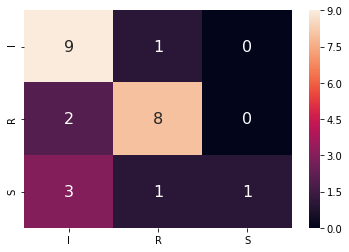

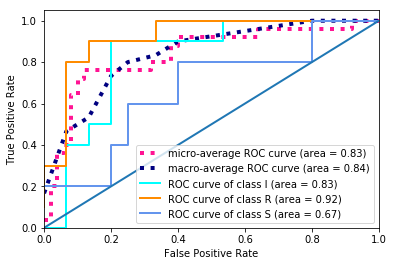


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.64      0.90      0.75        10
          R       0.80      0.80      0.80        10
          S       1.00      0.20      0.33         5

avg / total       0.78      0.72      0.69        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
          R       1.00      1.00      1.00        23
          S       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        56

Misclassified labels
Index(['12/5-29-12/4-16-13', '12/4-16-13/5-29-12', '12/4-16-13/5-24-14',
       '26/3-19-15/3-10-16', '9/6-20-18/3-23-17', '9/3-9-16/3-23-17',
       '1/8-16-12/11-20-13'],
      dtype='object')
Predicted class
['I' 'R' 'R' 'R' 'R' 'R' 'R' 'I' 'R' 'R' 'I' 'R' 'R' 'I' 'R' 'R' 'I' 'R'
 'R' 'R' 'I' 'R' 'R' 'I' 'R']
Actual class
12/5-29

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:142: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [27]:
# norm cnn
train_ensemble(X,y, eclf_multi, multiclass=True, cv=6, show_incorrect=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'voting': 'soft', 'weights': [1, 0]}

Grid scores on development set:

0.768 (+/-0.218) for {'voting': 'soft', 'weights': [1, 2]}
0.696 (+/-0.243) for {'voting': 'soft', 'weights': [1, 3]}
0.464 (+/-0.256) for {'voting': 'soft', 'weights': [0, 1]}
0.839 (+/-0.188) for {'voting': 'soft', 'weights': [1, 0]}
0.839 (+/-0.188) for {'voting': 'soft', 'weights': [2, 1]}
0.839 (+/-0.188) for {'voting': 'soft', 'weights': [3, 1]}
0.839 (+/-0.188) for {'voting': 'soft', 'weights': [4, 1]}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



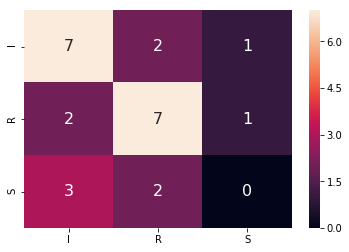

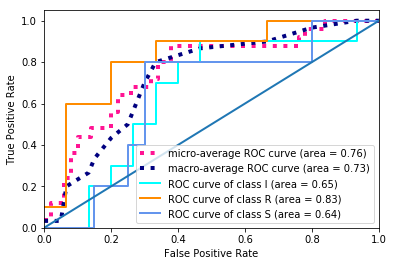


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.58      0.70      0.64        10
          R       0.64      0.70      0.67        10
          S       0.00      0.00      0.00         5

avg / total       0.49      0.56      0.52        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
          R       1.00      1.00      1.00        23
          S       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        56

Misclassified labels
Index(['12/5-29-12/4-16-13', '35/10-15-15/9-4-14', '7b/4-10-12/5-28-15',
       '12/4-16-13/5-29-12', '12/4-16-13/5-24-14', '12/4-16-13/3-13-15',
       '26/3-19-15/3-10-16', '10/11-7-12/9-22-16', '9/3-9-16/3-23-17',
       '7b/5-28-15/4-10-12', '1/8-16-12/11-20-13'],
      dtype='object')
Predicted class
['I' 'R' 'I' 'R' 'I' 'R' 'R

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:142: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


VotingClassifier(estimators=[('cnn', Pipeline(steps=[('col_extract_cnn', ColumnExtractor(pref='cnn_')), ('cnn_model', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=3000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=No...  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         n_jobs=1, voting='soft', weights=[1, 0])

In [9]:
train_ensemble(X,y, eclf_multi, multiclass=True, cv=6, show_incorrect=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'voting': 'soft', 'weights': [2, 1]}

Grid scores on development set:

0.857 (+/-0.218) for {'voting': 'soft', 'weights': [1, 2]}
0.821 (+/-0.246) for {'voting': 'soft', 'weights': [1, 3]}
0.518 (+/-0.099) for {'voting': 'soft', 'weights': [0, 1]}
0.875 (+/-0.142) for {'voting': 'soft', 'weights': [2, 1]}
0.875 (+/-0.142) for {'voting': 'soft', 'weights': [3, 1]}
0.875 (+/-0.142) for {'voting': 'soft', 'weights': [4, 1]}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



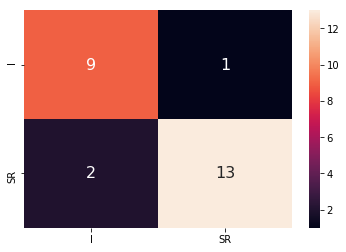

ROC AUC score
0.926666666667


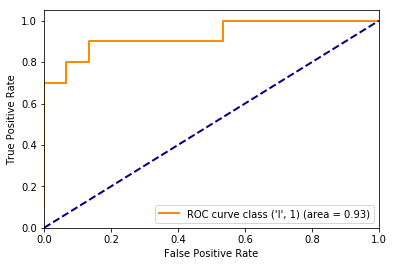


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.82      0.90      0.86        10
         SR       0.93      0.87      0.90        15

avg / total       0.88      0.88      0.88        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
         SR       1.00      1.00      1.00        33

avg / total       1.00      1.00      1.00        56

Misclassified labels
Index(['7b/5-28-15/4-10-12', '7b/4-10-12/5-28-15', '1/11-20-13/10-06-14'], dtype='object')
Predicted class
['I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I'
 'I' 'I' 'I' 'I' 'I' 'I' 'I']
Actual class
7b/5-28-15/4-10-12     SR
7b/4-10-12/5-28-15      I
1/11-20-13/10-06-14    SR
Name: y, dtype: object


/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:142: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


VotingClassifier(estimators=[('cnn', Pipeline(steps=[('col_extract_cnn', ColumnExtractor(pref='cnn_')), ('cnn_model', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=3000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver...  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         n_jobs=1, voting='soft', weights=[2, 1])

In [26]:
# norm cnn
train_ensemble(X,y, eclf_binary, multiclass=False, cv=6, show_incorrect=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'voting': 'soft', 'weights': [1, 0]}

Grid scores on development set:

0.821 (+/-0.243) for {'voting': 'soft', 'weights': [1, 2]}
0.750 (+/-0.213) for {'voting': 'soft', 'weights': [1, 3]}
0.518 (+/-0.099) for {'voting': 'soft', 'weights': [0, 1]}
0.839 (+/-0.132) for {'voting': 'soft', 'weights': [1, 0]}
0.839 (+/-0.109) for {'voting': 'soft', 'weights': [2, 1]}
0.839 (+/-0.132) for {'voting': 'soft', 'weights': [3, 1]}
0.839 (+/-0.132) for {'voting': 'soft', 'weights': [4, 1]}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



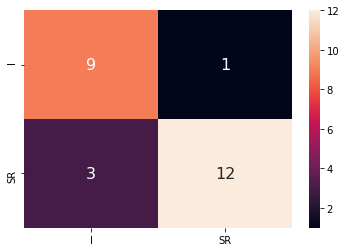

ROC AUC score
0.966666666667


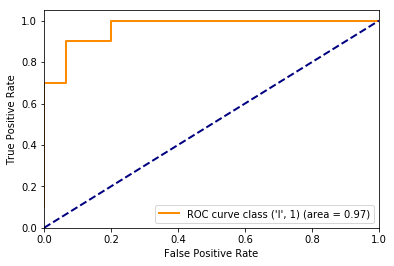


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.75      0.90      0.82        10
         SR       0.92      0.80      0.86        15

avg / total       0.85      0.84      0.84        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
         SR       1.00      1.00      1.00        33

avg / total       1.00      1.00      1.00        56

Misclassified labels
Index(['7b/5-28-15/4-10-12', '7b/4-10-12/5-28-15', '35/10-15-15/12-28-17',
       '1/11-20-13/10-06-14'],
      dtype='object')
Predicted class
['I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I'
 'I' 'I' 'I' 'I' 'I' 'I' 'I']
Actual class
7b/5-28-15/4-10-12      SR
7b/4-10-12/5-28-15       I
35/10-15-15/12-28-17    SR
1/11-20-13/10-06-14     SR
Name: y, dtype: object


/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:142: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


VotingClassifier(estimators=[('cnn', Pipeline(steps=[('col_extract_cnn', ColumnExtractor(pref='cnn_')), ('cnn_model', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=3000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver...  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         n_jobs=1, voting='soft', weights=[1, 0])

In [11]:
train_ensemble(X,y, eclf_binary, multiclass=False, cv=6, show_incorrect=True)

In [63]:

# this is just some extra examples of how we can train sub-models

params = {'lr__C': [1.0, 100.0],
      'svm__C': [2,3,4],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)


tuned_parameters = [
  {
    'estimator__kernel': ['rbf'],
    'estimator__gamma': [1e-3, 1e-4],
    'estimator__C': [1, 10, 100, 1000]
  },
  {
    'estimator__kernel': ['linear'], 
    'estimator__C': [1, 10, 100, 1000]
  }
]

model_to_set = OneVsRestClassifier(SVC(), n_jobs=-1)
clf = GridSearchCV(model_to_set, tuned_parameters)
clf.fit(X_train, y_train)

NameError: name 'OneVsRestClassifier' is not defined